## Imports

In [1]:
%matplotlib inline
!pip install wandb
!wandb login

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 39.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 kB 25.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 203.3/203.3 kB 27.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 9.1 MB/s eta 0:00:00
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8791 sha256=da20771a202775e961ea5e25ea74ddd0e9e02797c1d620dc610644c0db00b4ac
  Stored in directory: /root/.cache/pip/wheels/e7/f3/22/152153d6eb222ee7a56ff8617d80ee5207207a8c00a7aab794
Successfully built pathtools
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or pr

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Subset
from torch.utils.data import dataloader
import torch.nn as nn
import torch.nn.functional as F
# import wandb
import torch.optim as optim
import torchvision.utils as vutils
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
from google.colab import drive
drive.mount('/content/drive', force_remount=True)


Mounted at /content/drive


## Load Dataset

In [2]:
transform = transforms.Compose(
    [transforms.ToTensor()])

trainset = torchvision.datasets.MNIST(root='./data', train=True,
                                        download=True, transform=transform)

testset = torchvision.datasets.MNIST(root='./data', train=False,
                                       download=True, transform=transform)


100%|██████████| 9912422/9912422 [00:00<00:00, 103119734.02it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 112266630.05it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 22039801.64it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 23902796.45it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



##Helper Functions

###Initalize W&B

In [4]:
def init_wb():
  # start a new wandb run to track this script
  wandb.init(
      # set the wandb project where this run will be logged
      project="NN.Ex3",
      
      # track hyperparameters and run metadata
      config={
      "learning_rate": lr,
      "architecture": "GAN",
      "dataset": "MNIST",
      "epochs": num_epochs,
      "device": device,
      "#neurons": sum(p.numel() for p in G.parameters() if p.requires_grad + 
                      p.numel() for p in D.parameters() if p.requires_grad),
      "Loss": criterion,
      "D steps": D_steps,
      "saturated": saturated
      }
  )


### Train network


In [3]:
def train(G, D, dataloader, optimizerG, optimizerD, criterion, num_epochs, device, D_steps, saturated):
  iters = 0
  print("Starting Training Loop...")
  for epoch in range(num_epochs):
      for i, data in enumerate(dataloader, 0):
        # Format batch
        real = data[0].to(device)
        b_size = real.size(0)
        
        
        ############################
        # (1) Update D network: 
        ###########################
        # for BCE it maximize log(D(x)) + log(1 - D(G(z)))
        # for MSE it minimize (D(x)-1)^2 + (D(G(z))^2

        D.zero_grad()
        ## Train with real batch
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        output = D(real).view(-1)
        errD_real = criterion(output, label)
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with fake batch
        noise = torch.randn(b_size, latent_dim, device=device)
        fake = G(noise)
        label.fill_(fake_label)
        output = D(fake.detach()).view(-1)
        errD_fake = criterion(output, label)
        errD_fake.backward()
        D_G_z1 = output.mean().item()

        # Update D
        errD = errD_real + errD_fake
        optimizerD.step()

        ############################
        # (2) Update G network:
        ###########################
        if i % D_steps == 0:
          G.zero_grad()
          output = D(fake).view(-1)
          if saturated:
            # minimize log(1 - D(G(z)))
            label.fill_(fake_label)
            errG = -criterion(output, label) 
          else:
            # maximize log(D(G(z)))
            label.fill_(real_label)
            errG = criterion(output, label)
          errG.backward()
          D_G_z2 = output.mean().item()
          optimizerG.step()
        
        # Output training stats
        if i == len(dataloader) - 1:
            print('[%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch+1, num_epochs, errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))
        
        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())
        
        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 300 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = G(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))
            
        iters += 1
      wandb.log({"Loss G": np.mean(G_losses[-len(dataloader):]), "Loss D": np.mean(D_losses[-len(dataloader)])})

  print('Finished Training')

###Weight Initialization
From the DCGAN paper, the authors specify that all model weights shall be randomly initialized from a Normal distribution with mean=0, stdev=0.02. The weights_init function takes an initialized model as input and reinitializes all convolutional, convolutional-transpose, and batch normalization layers to meet this criteria. This function is applied to the models immediately after initialization.

In [4]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

## Define Learning Model Classes

In [5]:
class Generator(nn.Module):
    def __init__(self, latent_dim):
        super(Generator, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(latent_dim, 7*7*256),
            # nn.BatchNorm1d(7*7*256),
            nn.ReLU()
        )
        self.conv_transpose = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 1, kernel_size=3, stride=1, padding=1),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        x = self.fc(x)
        x = x.view(-1, 256, 7, 7)
        x = self.conv_transpose(x)
        return x

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),
        )
        self.fc = nn.Sequential(
            nn.Linear(256*7*7, 1),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        x = self.conv(x)
        x = x.view(-1, 256*7*7)
        x = self.fc(x)
        return x


# Main

In [6]:
# Define some hyperparameters

batch_size = 128  # Batch size during training

latent_dim = 100  # Size of z latent vector

num_epochs = 20  # Number of training epochs

lr = 0.0002 # Learning rate for optimizers

D_steps_list = [3] # Number of iterations for the descriminator per one iteration for the generator 

# Different losses for part 1 loss-saturation
criterions = [nn.BCELoss()]

beta1 = 0.5 # Beta1 hyperparameter for Adam optimizers
beta2 = 0.999 # Beta2 hyperparameter for Adam optimizers

# Set device to GPU if available, set seed for same outputs each run
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
torch.manual_seed(0)

# PATH to drive
PATH = '/content/drive/MyDrive/NN4I/Ex3/'
model_path = "/content/drive/MyDrive/NN4I/Ex3/G_BCELoss()_2_False.pth"

# Create dataloaders (should we use train and test?)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                            shuffle=False, num_workers=2)

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(64, latent_dim, device=device)

cuda


criterion_MSELoss()_Dsteps_3_saturated_False
Starting Training Loop...
[1/20]	Loss_D: 0.2826	Loss_G: 0.7880	D(x): 0.5959	D(G(z)): 0.0464 / 0.1269
[2/20]	Loss_D: 0.0326	Loss_G: 0.8806	D(x): 0.9312	D(G(z)): 0.1206 / 0.0632
[3/20]	Loss_D: 0.0242	Loss_G: 0.7953	D(x): 0.9001	D(G(z)): 0.0274 / 0.1128
[4/20]	Loss_D: 0.1105	Loss_G: 0.9674	D(x): 0.9490	D(G(z)): 0.2526 / 0.0166
[5/20]	Loss_D: 0.0646	Loss_G: 0.8869	D(x): 0.9350	D(G(z)): 0.1932 / 0.0593
[7/20]	Loss_D: 0.4614	Loss_G: 0.7435	D(x): 0.3769	D(G(z)): 0.0232 / 0.1588
[8/20]	Loss_D: 0.1584	Loss_G: 0.8870	D(x): 0.9729	D(G(z)): 0.3167 / 0.0608
[9/20]	Loss_D: 0.0577	Loss_G: 0.8236	D(x): 0.9076	D(G(z)): 0.1419 / 0.0971
[10/20]	Loss_D: 0.0173	Loss_G: 0.9113	D(x): 0.9529	D(G(z)): 0.0927 / 0.0460
[11/20]	Loss_D: 0.0459	Loss_G: 0.7955	D(x): 0.8498	D(G(z)): 0.0448 / 0.1155
[12/20]	Loss_D: 0.0329	Loss_G: 0.8376	D(x): 0.9097	D(G(z)): 0.0807 / 0.0890
[13/20]	Loss_D: 0.0957	Loss_G: 0.7831	D(x): 0.7594	D(G(z)): 0.0227 / 0.1222
[14/20]	Loss_D: 0.0301	Lo

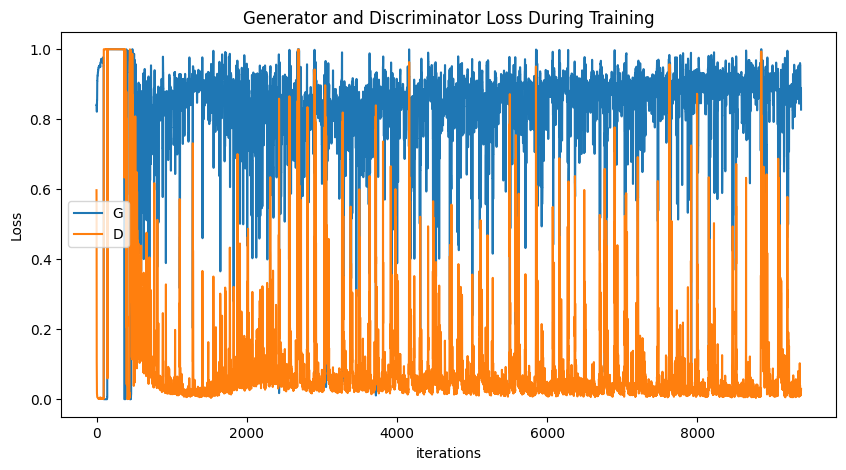

In [29]:
for D_steps in D_steps_list:
  saturated = False
  for criterion in criterions:

    # Create Generator and Descriptor
    G = Generator(latent_dim).to(device)
    G.apply(weights_init)
    D = Discriminator().to(device)
    D.apply(weights_init)

    # Init wandb
    init_wb()

    # Lists to keep track of progress
    G_losses = []
    D_losses = []
    img_list = []

    # Establish convention for real and fake labels during training
    real_label = 1.
    fake_label = 0.

    # Setup Adam optimizers for both G and D
    optimizerD = optim.Adam(D.parameters(), lr=lr, betas=(beta1, beta2))
    optimizerG = optim.Adam(G.parameters(), lr=lr, betas=(beta1, beta2))

    print(f'criterion_{criterion}_Dsteps_{D_steps}_saturated_{saturated}')
    # Train
    train(G, D, trainloader, optimizerG, optimizerD, criterion, num_epochs, device, D_steps, saturated)
    

    # Save only the model state dictionary
    torch.save(G.state_dict(), PATH +f'G_{criterion}_{D_steps}_{saturated}.pth')
    torch.save(D.state_dict(), PATH +f'D_{criterion}_{D_steps}_{saturated}.pth')

    # Plot losses
    plt.figure(figsize=(10,5))
    plt.title("Generator and Discriminator Loss During Training")
    plt.plot(G_losses,label="G")
    plt.plot(D_losses,label="D")
    plt.xlabel("iterations")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

    saturated = False

    wandb.finish()




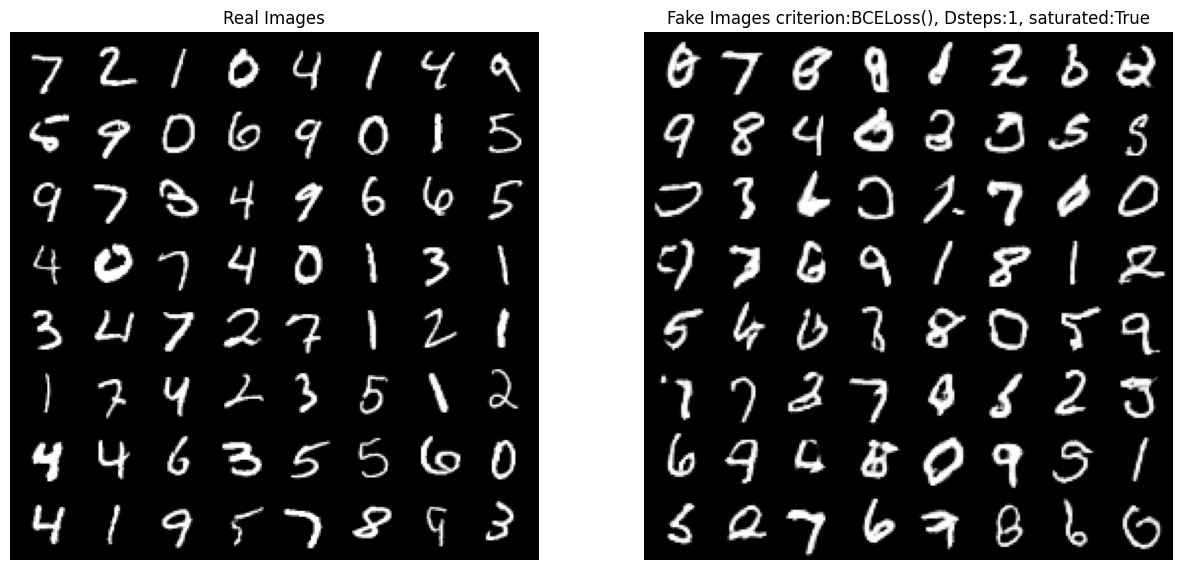

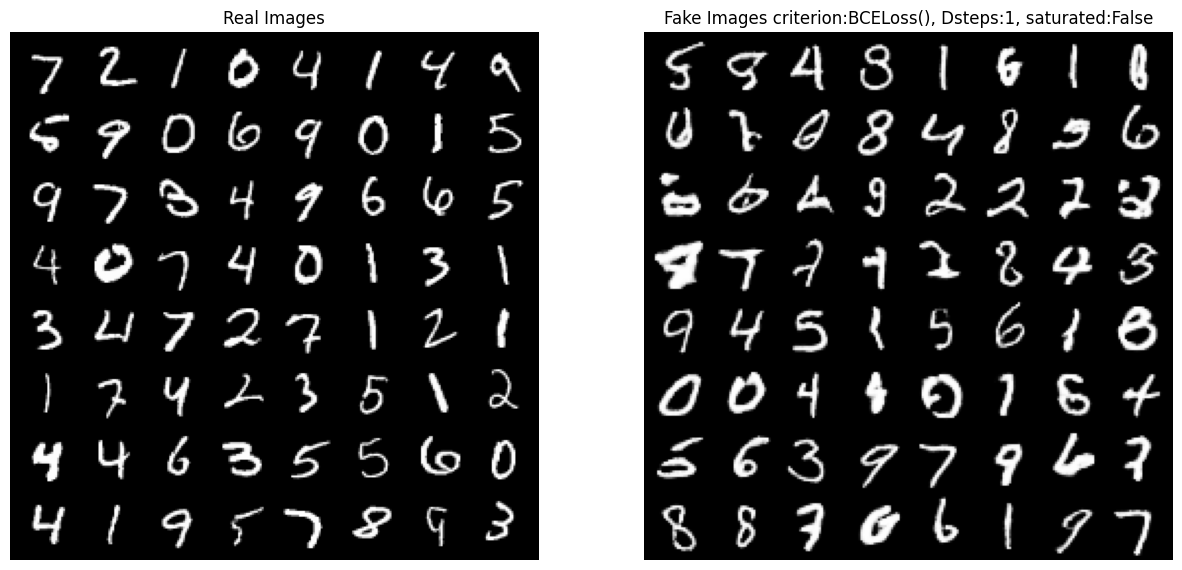

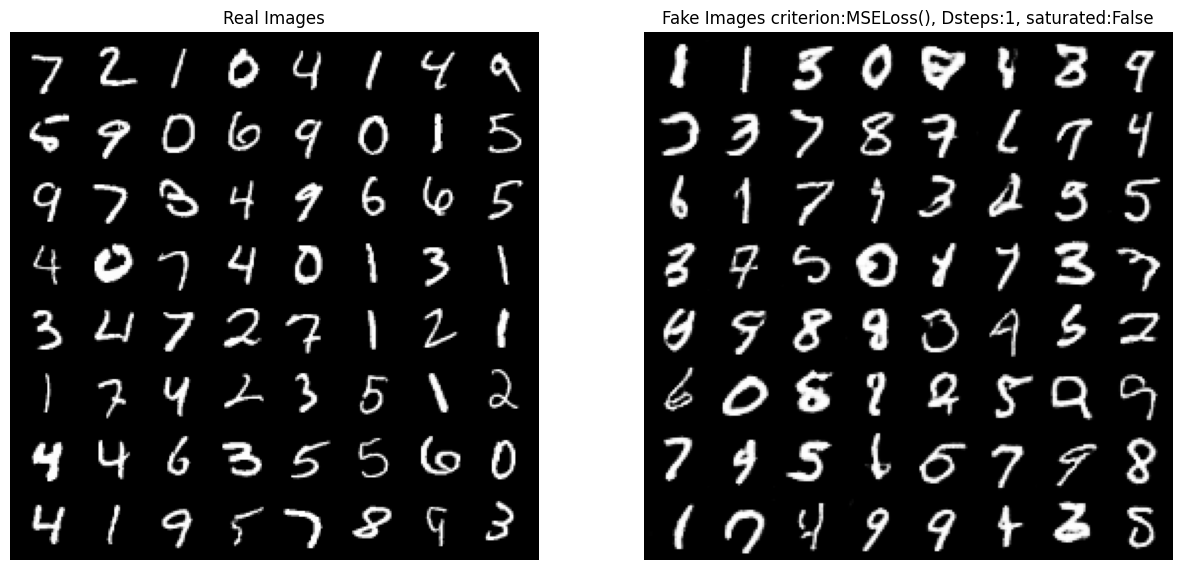

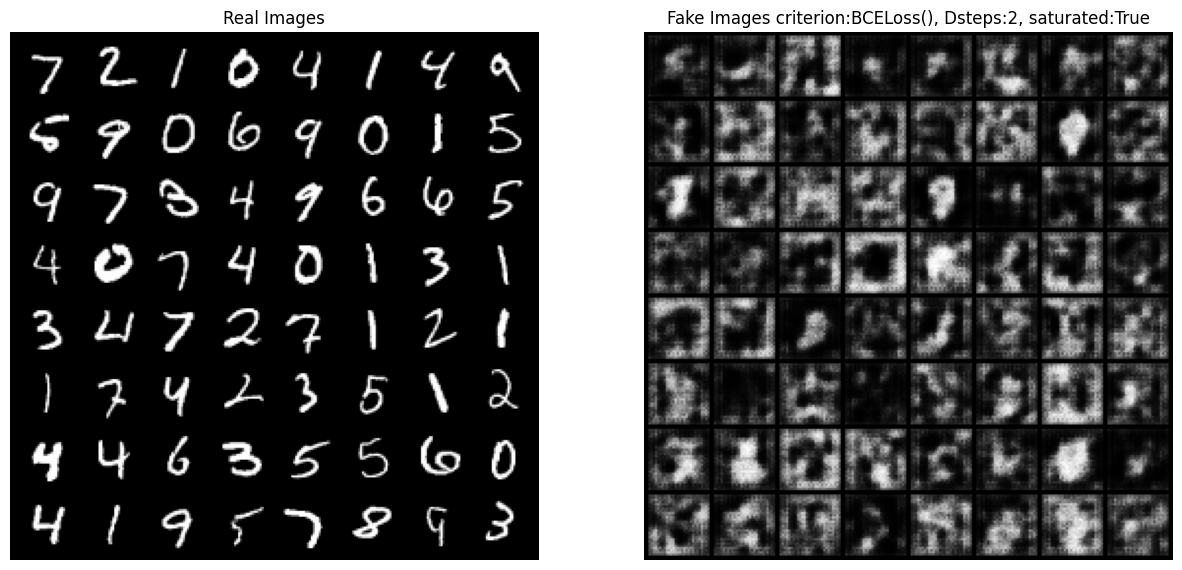

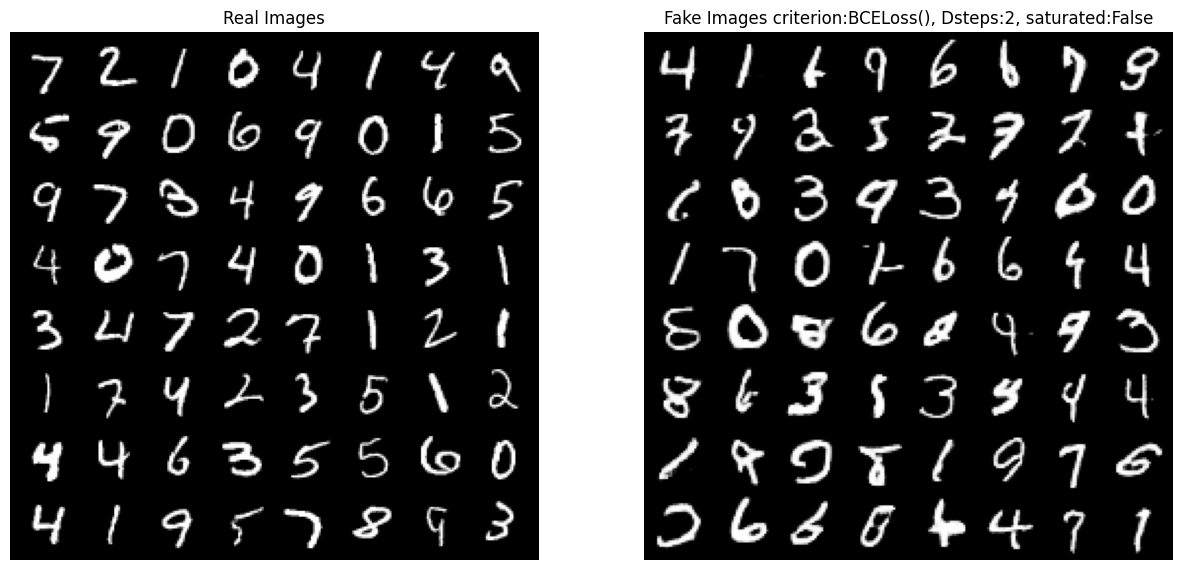

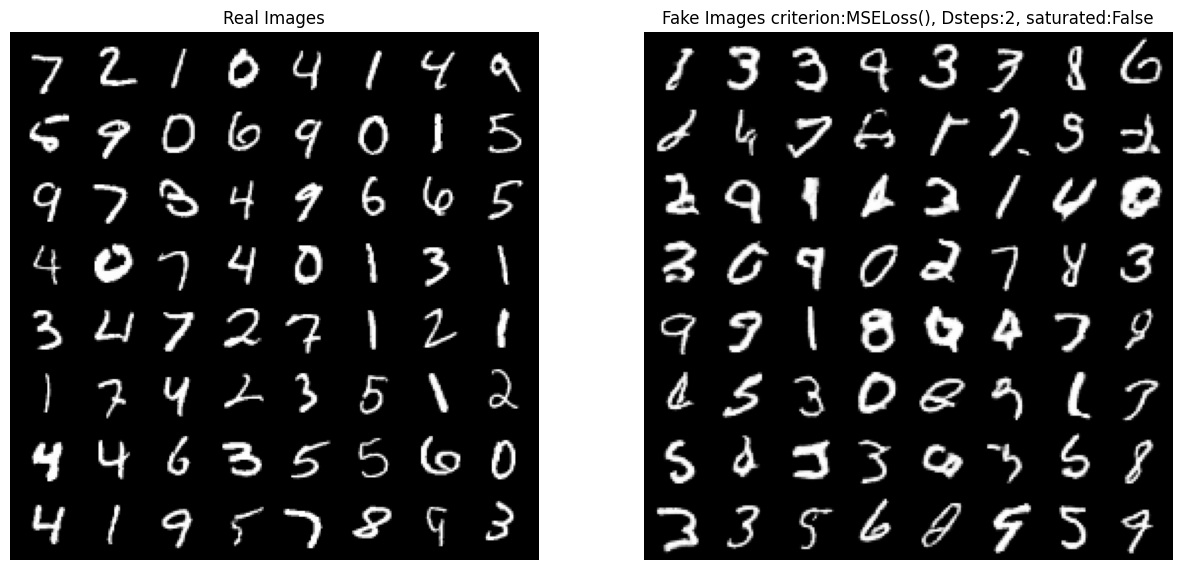

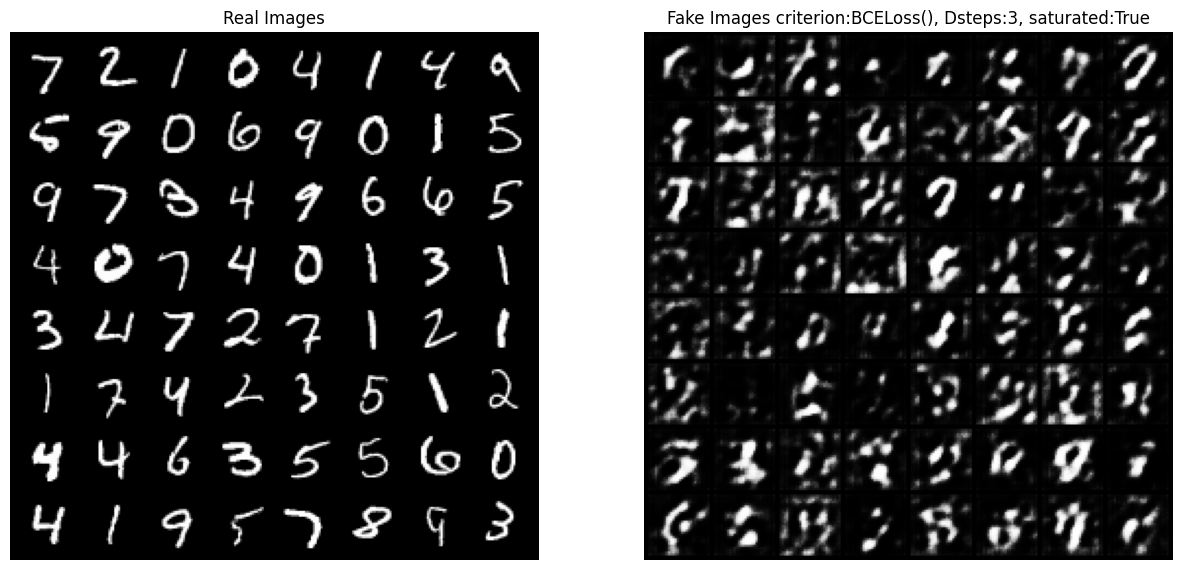

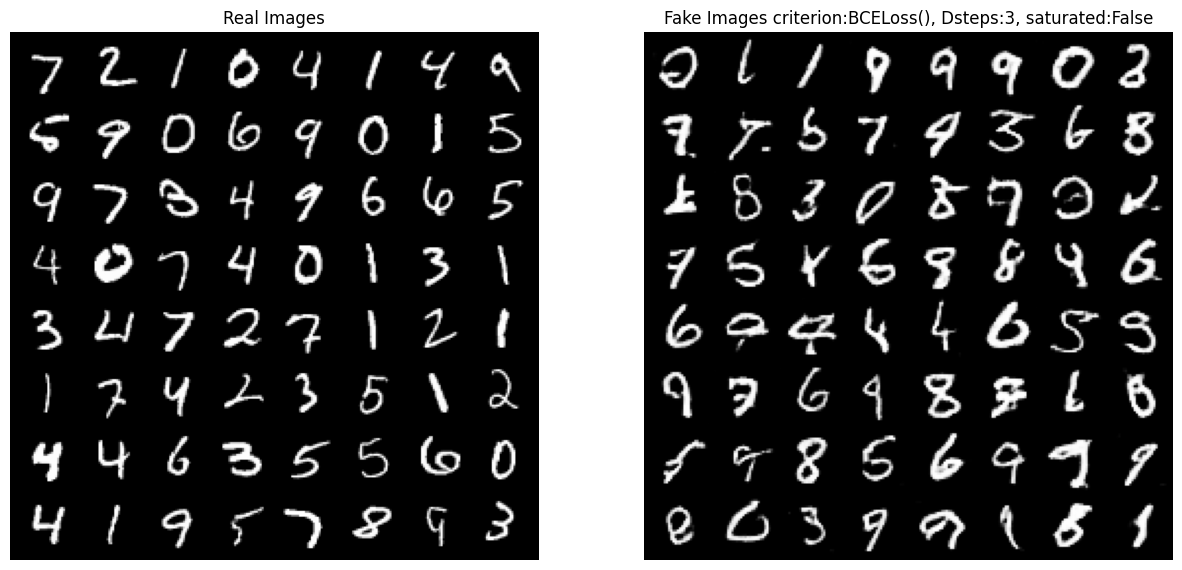

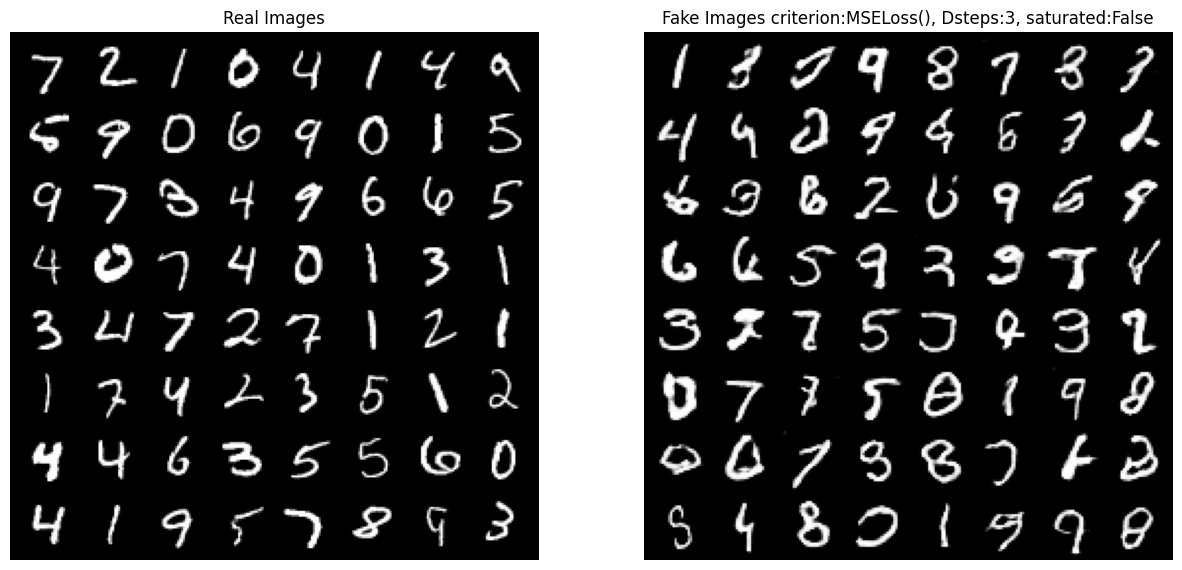

In [35]:
for D_steps in D_steps_list:
  saturated = True
  for criterion in criterions:
    # load the saed model
    G = Generator(latent_dim).to(device)
    G.load_state_dict(torch.load(PATH + f'G_{criterion}_{D_steps}_{saturated}.pth'))
    G.eval()
    D = Discriminator().to(device)
    D.load_state_dict(torch.load(PATH + f'D_{criterion}_{D_steps}_{saturated}.pth'))
    D.eval()

    model_description = f' criterion:{criterion}, Dsteps:{D_steps}, saturated:{saturated}'
    saturated = False


    # Grab a batch of real images from the dataloader
    real_batch = next(iter(testloader))
    # Plot the real images
    plt.figure(figsize=(15,15))
    plt.subplot(1,2,1)
    plt.axis("off")
    plt.title("Real Images")
    plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))
    # Plot the fake images from the last epoch
    plt.subplot(1,2,2)
    plt.axis("off")
    plt.title("Fake Images" + model_description)
    fake = G(fixed_noise).detach().cpu()
    plt.imshow(np.transpose(vutils.make_grid(fake, padding=2, normalize=True),(1,2,0)))
    plt.show()

## Model Inversion

In [7]:
def invert_image(G, image, device, num_steps=1000, lr=0.1, norm='l2'):
    z = torch.randn(1, latent_dim, device=device, requires_grad=True)
    optimizer = optim.Adam([z], lr)
    criterion = nn.MSELoss() if norm == 'l2' else nn.L1Loss()
    
    for step in range(num_steps):
        optimizer.zero_grad()
        fake_image = G(z)
        loss = criterion(image, fake_image)
        loss.backward()
        optimizer.step()
        
    return z.detach()



def image_reconstruction(model_path, image, device, norm='l2'):
    # Instantiate and load the pre-trained generator model
    G = Generator(latent_dim).to(device)
    G.load_state_dict(torch.load(model_path))
    G.eval()

    inverted_z = invert_image(G, image, device, num_steps=1000, lr=0.1, norm=norm)

    return G(inverted_z)

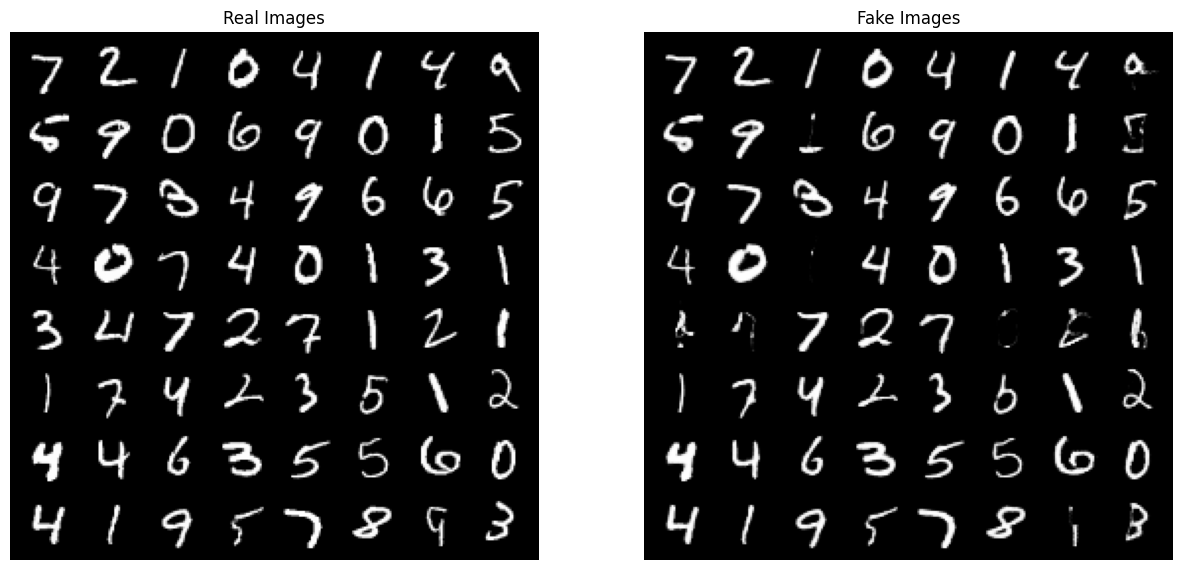

In [28]:
# Grab a batch of real images from the dataloader
real_batch = next(iter(testloader))
batch = real_batch[0].to(device)[:64]
# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(batch, padding=5, normalize=True).cpu(),(1,2,0)))

plt.subplot(1,2,2)
plt.axis("off")
plt.title("Reconstructed Images")
fake_images = []
model_path = '/content/drive/MyDrive/NN4I/Ex3/G_BCELoss()_2_False.pth'
for image in batch:
    reconstructed_image = image_reconstruction(model_path, image.unsqueeze(0), device)
    fake_images.append(reconstructed_image)
fake_images = torch.cat(fake_images, dim=0)
fake_grid = vutils.make_grid(fake_images, padding=5, normalize=True)
plt.imshow(np.transpose(fake_grid.cpu(), (1,2,0)))
plt.show()

    


##Image Restoration

In [11]:
def add_noise(image, std=0.1):
    noise = torch.randn_like(image) * std
    noisy_image = torch.clamp(image + noise, min=0, max=1)
    return noisy_image

def create_holes(image, hole_size=8):
    height, width = image.size(1), image.size(2)
    mask = np.ones((height, width), dtype=bool)
    start_h = np.random.randint(0, height - hole_size)
    start_w = np.random.randint(0, width - hole_size)
    mask[start_h:start_h + hole_size, start_w:start_w + hole_size] = False

    corrupted_image = image.clone()
    corrupted_image[:, start_h:start_h + hole_size, start_w:start_w + hole_size] = 0.
    return corrupted_image


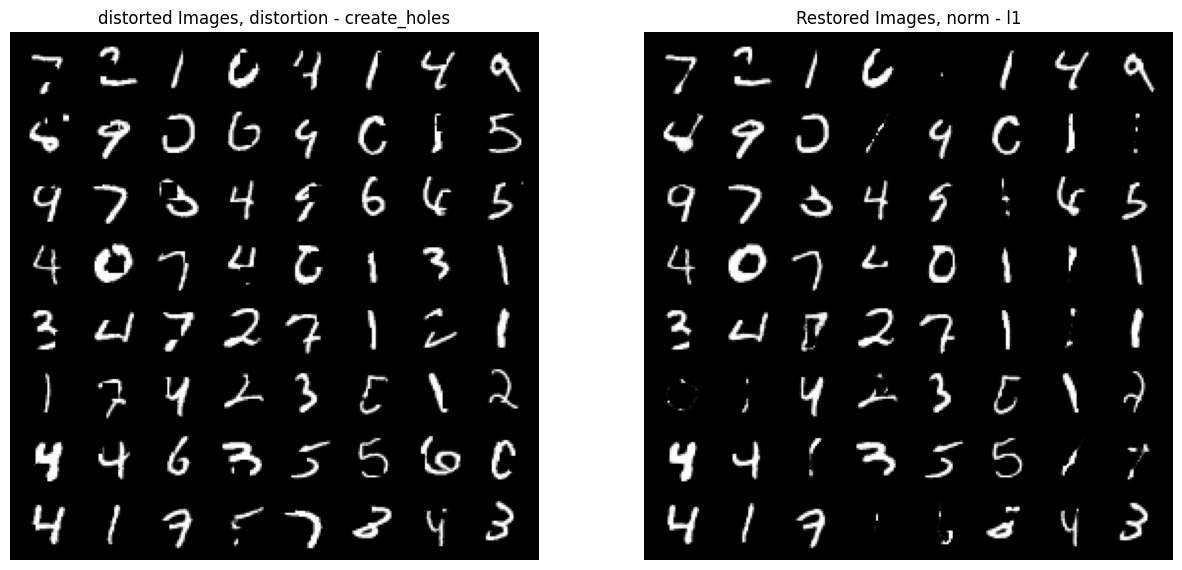

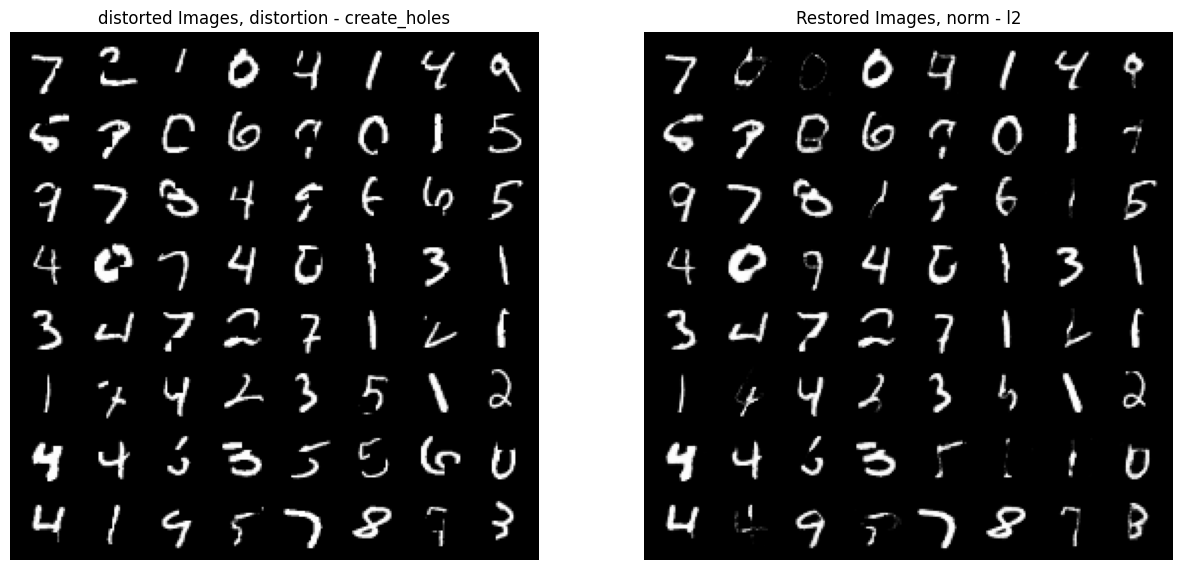

In [12]:
model_path = '/content/drive/MyDrive/NN4I/Ex3/G_BCELoss()_2_False.pth'
for distortion in [create_holes]:
  for norm in ['l1', 'l2']:
    # Denoising - Restoration of Noisy Images
    # Grab a batch of real images from the dataloader
    real_batch = next(iter(testloader))
    
    distorted_images = []
    for image in real_batch[0].to(device)[:64]:
        distorted_image = distortion(image)
        distorted_images.append(distorted_image)
    plt.figure(figsize=(15,15))
    plt.subplot(1,2,1)
    plt.axis("off")
    plt.title(f"distorted Images, distortion - {str(distortion).split(' ')[1]}")
    plt.imshow(np.transpose(vutils.make_grid(distorted_images, padding=5, normalize=True).cpu(),(1,2,0)))

    plt.subplot(1,2,2)
    plt.axis("off")
    plt.title(f"Restored Images, norm - {norm}")
    restored_images = []
    for distorted_image in distorted_images:
        restored_image = image_reconstruction(model_path, distorted_image.unsqueeze(0), device, norm)
        restored_images.append(restored_image)
    restored_images = torch.cat(restored_images, dim=0)
    fake_grid = vutils.make_grid(restored_images, padding=5, normalize=True)
    plt.imshow(np.transpose(fake_grid.cpu(), (1,2,0)))
    plt.show()

